# Email Sorting
Royce Schultz

## Abstract
I currently have 1,460 unread emails between my 2 primary accounts. Sorting all these messages is no quick task. The simplest method is a series of if statements like,
```
if (message.from('no-reply@piazza.com')): return label('piazza')

```
But more nuanced cases may require more care. For example, email lists may come from many differnt people. Additionally, those people may send you other emails for different contexts.

I will be looking specifically at identifying responses from job applications. My goal is to disinguish between confirmaiton emails, code tests, denials, offers, and spam recruiters.

In [7]:
from model import Gmail
from shingles import *
import matplotlib.pyplot as plt
import numpy as np
import random

## The Gmail Class

This custom class handles communication with the api. It can grab live messages and labels from the associated gmail account.

In [2]:
G = Gmail()

In [3]:
LABEL_NAMES = G.labels.names()

lets pick a label and identify charachteristic words in this group

In [4]:
myLabels = ['Job Applications']

In [5]:
messages = G.labels.match(myLabels)

In [6]:
print(len(messages))
print(messages[0])

84
{'id': '16e7151f00e3a48b', 'threadId': '16e7151f00e3a48b'}


### Creating a descriptive hash
The hash function shingles all messages it's given and identifies shingles that are common in at least **freq**% of messages

In [20]:
myHash = G.getHash(random.sample(messages,50), freq=0.15, k=8)

In [21]:
print(len(myHash))
print(myHash)

676
{' will be', 'hat you ', 'able to ', 'LinkedIn', 'ue to th', 'ndidate ', 'ing Inte', 'l contac', 'Regards,', 'view you', 'f there ', 'your app', 'unities ', 'n your c', 'r employ', 'gineerin', 'do not r', 'n status', 'as been ', ' Intern ', 'eam will', 'ackgroun', 'more abo', ' do not ', 'u have a', 'i Royce,', 'ved your', 't of luc', ' intervi', 'le an in', 'we encou', 'ualifica', 'candidat', 'ion for ', ' you to ', ' online ', 'nterest ', ' submitt', 'xperienc', 'ur appli', 'iew your', 'we appre', 'l not be', 'https://', 'ou for y', 'Recruiti', 'are Engi', 'his emai', 'ime and ', 'at Amazo', ' in touc', 'our expe', 'nd will ', 'evelopme', ' update ', 'iewing y', 'ng Inter', 'se your ', 'ext step', 'siderati', 'llo Royc', ' your ex', 'on for t', 'reach ou', ' if ther', 'cruiting', 'r your i', 'o schedu', 'eceived ', 'ortuniti', 'cation f', 'the best', 'uiting t', ' this po', ' of our ', 'ecruiter', 'ease do ', ' for thi', 'e review', ' time an', 'e requir', ' of appl', ' at Amaz',

In [22]:
myHash.filter(.3)
print(len(myHash))
print(myHash)

181
{' will be', 'our appl', 'hat you ', 'able to ', 'nk you f', 'ng team ', 'portunit', 'you for ', ' review ', 'your app', 'unities ', 'eived yo', 'ou have ', ' Intern ', 'eam will', 'we will ', 'ore abou', 'more abo', 'for the ', 'i Royce,', ' please ', ' to the ', 'oftware ', 'ved your', ' for the', 'ualifica', 'ing the ', 'candidat', 'ion for ', 'or your ', ' you to ', ' opportu', 'nterest ', 'tware En', 'xperienc', 'ur appli', 'pportuni', 'lication', ' Royce,T', 'am will ', 'https://', 'ou for y', 'qualific', 'Recruiti', 'are Engi', 'e,Thank ', 'his emai', 'nd will ', 'opportun', 'ed your ', 'u for yo', ' of the ', 'e about ', 'consider', 'on for t', 'cruiting', 'r your i', 'ceived y', 'rest in ', 'eceived ', 'ortuniti', 'cation f', 'for your', 'will be ', 'Royce,Th', ' experie', 'applicat', 'our inte', ' of our ', ' more ab', ' candida', 'ce,Thank', 'r applic', 'informat', 'received', 'alificat', ' receive', 'ftware E', 'you have', 'Hi Royce', 'will not', 'ormation', 'ication ',

### Evaluating the hash
Let's see how messages in the group compare to the hash

(array([ 6.,  7., 14., 10., 17., 14.,  2.,  2.,  5.,  7.]),
 array([0.3038674 , 0.34530387, 0.38674033, 0.4281768 , 0.46961326,
        0.51104972, 0.55248619, 0.59392265, 0.63535912, 0.67679558,
        0.71823204]),
 <a list of 10 Patch objects>)

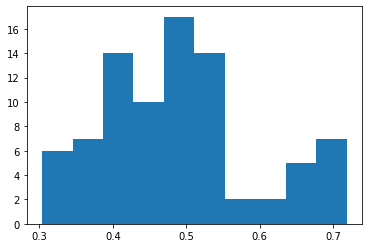

In [23]:
scores = []
for i, message in enumerate(messages):
    print(i, end='\r')
    content = G.messages.parseMessage(message)
    s = myHash.sim(content)
    scores.append(s)
plt.hist(scores)

In [24]:
ranks = np.argsort(scores)

for i in ranks[:5]:
    print(G.messages.readMessage(messages[i])[:100])


Hello Royce!

Thank you for your interest in Amazon and for taking the time to complete the
onli

Dear Royce
Thank you for your interest in 2020 Summer Analyst - Technology - Software Engineering -

Hi Royce,

Thank you for your interest in the Data Scientist, Intern 2020 role; your application 

Hi Royce,

Thank you for your interest in Khan Academy! We appreciate the time you spent on your 

Dear Royce,

Thank you for giving us the opportunity to consider you for the role. We have review


In [25]:
for i in ranks[-5:]:
    print(G.messages.readMessage(messages[i])[:100])


Hello Royce,

 Thank you for your interest in joining the team at Tesla. We’ve received your appl

Hello Royce,

 Thank you for your interest in joining the team at Tesla. We’ve received your appl

Hello Royce,

 Thank you for your interest in joining the team at Tesla. We’ve received your appl

Hello Royce,

 Thank you for your interest in joining the team at Tesla. We’ve received your appl

Hello Royce,

 Thank you for your interest in joining the team at Tesla. We’ve received your appl


### Huh, that might be a problem
This method is very sensative to initialization. It will favor 'template' emails that are literally identical in large chunks of their content.

### Identifying new messages
Now that we've done the hard part by sampling lots of examples of a label, matching the label to a new message is pretty easy.

In [30]:
for i in range(100):
    print(i,end='\r')
    message = G.messages.popMessage()
    content = G.messages.parseMessage(message)
    s = myHash.sim(content)
    if s > .3:
        print(content[:100])

Hi Royce,Thank you so much for your time and strong interest in PlayStation. Unfortunately, we have 
Hi Royce,Thanks for submitting your application to GitHub! Your information has been personally revi
To view this email as a web page, click here.---------------------------------------- http://click.s
Hello Royce,Thank you for your interest in the role at Lyft! At this time, we will not be able to mo
